In [ ]:
import pandas as pd

In [ ]:
data=pd.read_csv("/content/earthquakes_1950_2024.csv")

In [ ]:
data.head()

,Time,Latitude,Longitude,Magnitude
0,1964-12-30 23:37:44.300,36.13,70.00,4.9
1,1964-12-30 22:39:08.700,-38.70,175.80,4.4
2,1964-12-30 21:30:57.300,-23.33,-179.82,5.0
3,1964-12-30 16:49:49.300,41.30,142.02,4.2
4,1964-12-30 16:35:13.700,-32.64,-179.25,5.0


In [ ]:
data['Time'] = pd.to_datetime(data['Time'])
data = data.sort_values(by='Time').reset_index(drop=True)

In [ ]:
data.head()

,Time,Latitude,Longitude,Magnitude
0,1960-01-01 02:34:48,15.95,-100.13,5.1
1,1960-01-01 23:12:31,56.09,163.02,5.4
2,1960-01-02 03:21:48,-17.68,-69.21,6.2
3,1960-01-02 05:06:57,3.03,95.96,5.8
4,1960-01-02 06:59:36,55.91,163.25,5.6


In [ ]:
# prompt: convert time into Day, Month, Year, Hour, Minute and Second columns

data['Day'] = data['Time'].dt.day
data['Month'] = data['Time'].dt.month
data['Year'] = data['Time'].dt.year
data['Hour'] = data['Time'].dt.hour
data['Minute'] = data['Time'].dt.minute
data['Second'] = data['Time'].dt.second
data.drop('Time', axis=1, inplace=True)


In [ ]:
data.head()

,Latitude,Longitude,Magnitude,Day,Month,Year,Hour,Minute,Second
0,15.95,-100.13,5.1,1,1,1960,2,34,48
1,56.09,163.02,5.4,1,1,1960,23,12,31
2,-17.68,-69.21,6.2,2,1,1960,3,21,48
3,3.03,95.96,5.8,2,1,1960,5,6,57
4,55.91,163.25,5.6,2,1,1960,6,59,36


In [ ]:
data.shape

(693867, 9)

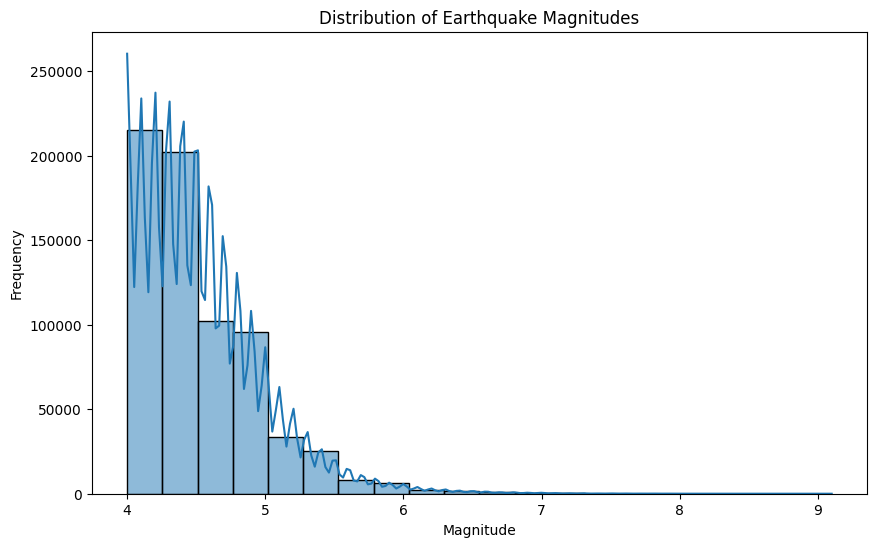

count    693867.000000
mean          4.523986
std           0.441429
min           4.000000
25%           4.200000
50%           4.400000
75%           4.800000
max           9.100000
Name: Magnitude, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data['Magnitude'], bins=20, kde=True)
plt.title('Distribution of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()

# Descriptive statistics
print(data['Magnitude'].describe())

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
# Select features and target
features = ['Magnitude','Latitude', 'Longitude', 'Year', 'Month', 'Day']
target = ['Magnitude']

X = data[features].values
y = data[target].values
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Scale data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

In [ ]:
# Reshape for LSTM (samples, timesteps, features)
# Ensure seq_length is consistent with the model's input shape
seq_length = 1  # Or whatever sequence length your model expects

X_train = X_train.reshape((X_train.shape[0], seq_length, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], seq_length, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], seq_length, X_test.shape[1]))

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 594.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense

input_shape = (seq_length, X_train.shape[2])

inputs = Input(shape=input_shape)
lstm_out = LSTM(32, return_sequences=True)(inputs)
drop = Dropout(0.3)(lstm_out)
attention = Attention()(drop)
dense1 = Dense(64, activation='relu')(attention)
output = Dense(len(target))(dense1)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 32)          │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 32)             │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,202 (28.13 KB)

 Trainable params: 7,202 (28.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]
)


Epoch 1/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 8.1666e-04 - val_loss: 7.5455e-04
Epoch 2/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 2.5401e-05 - val_loss: 0.0014
Epoch 3/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 7.7754e-06 - val_loss: 0.0019
Epoch 4/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 4.3841e-06 - val_loss: 0.0022
Epoch 5/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 3.0864e-06 - val_loss: 0.0021
Epoch 6/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 2.7690e-06 - val_loss: 0.0022
Epoch 7/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 2.6386e-06 - val_loss: 0.0024
Epoch 8/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 2.6948e-06 - val_loss: 0.0023
Epoch 9/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 2.2941e-06 - val_loss: 0.0022
Epoch 10/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 2.1195e-06 - val_loss: 0.0022
Epoch 11/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 1

In [ ]:
predictions_scaled = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE:", mean_squared_error(y_test_original, predictions))
print("MAE:", mean_absolute_error(y_test_original, predictions))

2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
MSE: 0.018875259816150295
MAE: 0.09425315426297828


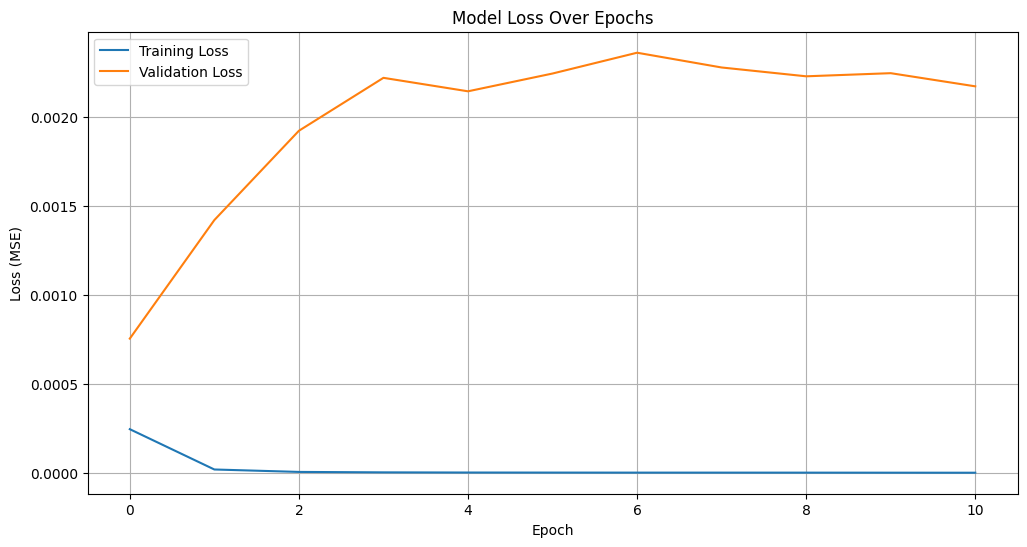

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

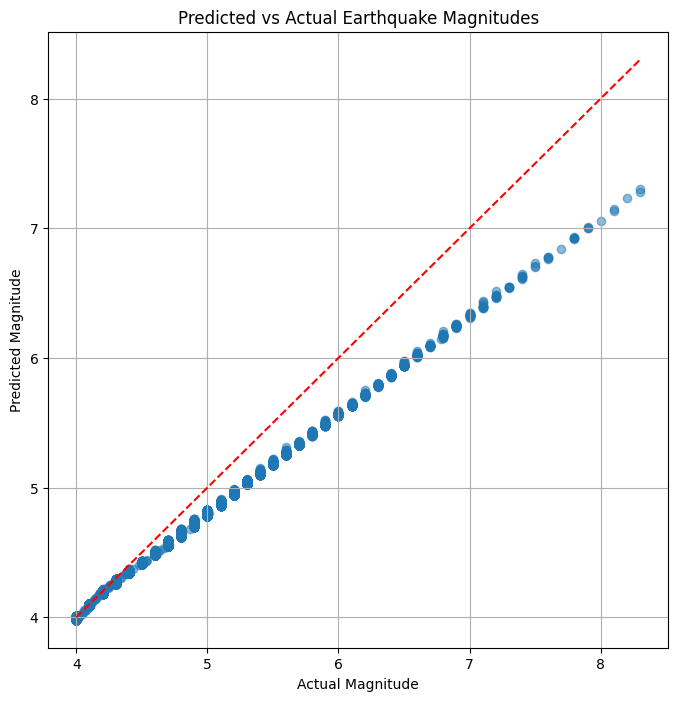

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original, predictions, alpha=0.5)
plt.plot([min(y_test_original), max(y_test_original)],
         [min(y_test_original), max(y_test_original)],
         color='red', linestyle='--')
plt.title('Predicted vs Actual Earthquake Magnitudes')
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.grid(True)
plt.show()

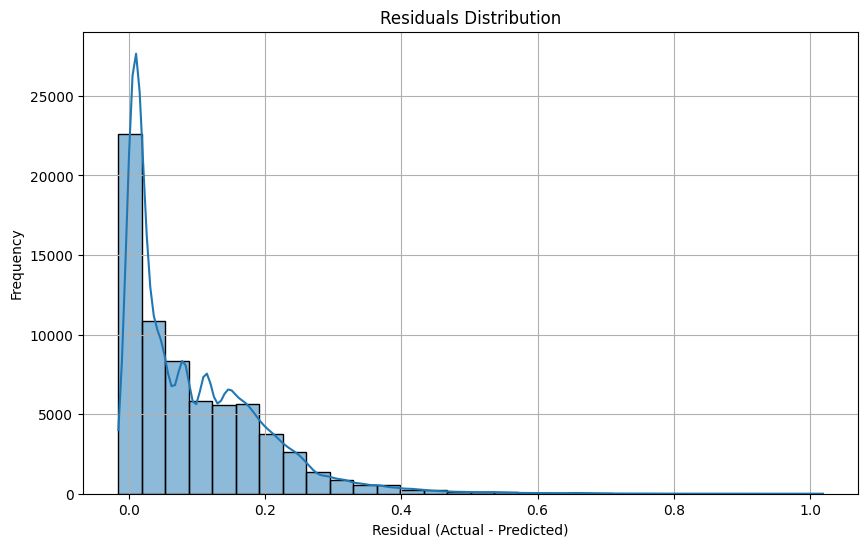

In [ ]:
residuals = y_test_original.flatten() - predictions.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

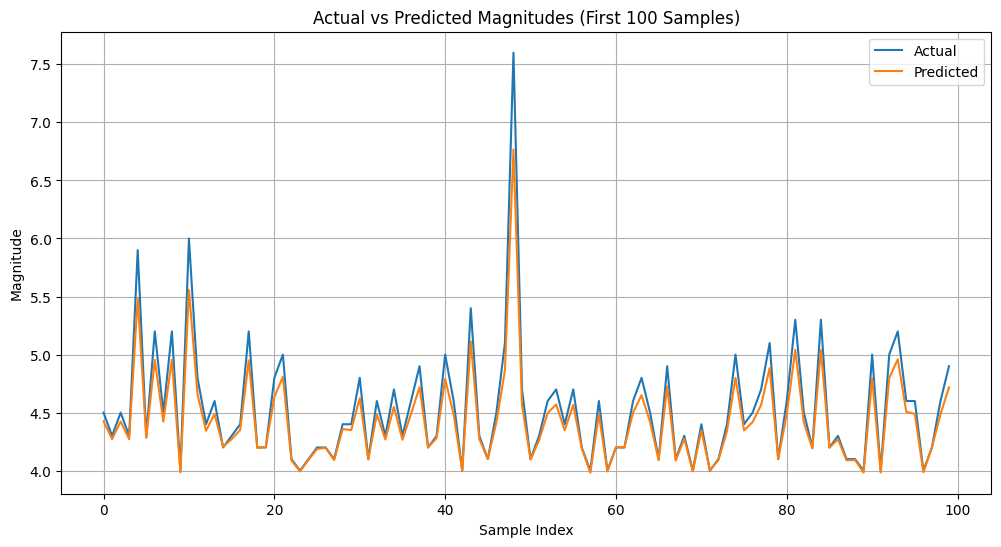

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.title('Actual vs Predicted Magnitudes (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()